In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('hacktrain.csv')
test_df = pd.read_csv('hacktest.csv')

print(train_df.info())
print(train_df['class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8000 non-null   int64  
 1   ID          8000 non-null   int64  
 2   class       8000 non-null   object 
 3   20150720_N  7440 non-null   float64
 4   20150602_N  6800 non-null   float64
 5   20150517_N  7200 non-null   float64
 6   20150501_N  7040 non-null   float64
 7   20150415_N  7520 non-null   float64
 8   20150330_N  6880 non-null   float64
 9   20150314_N  7280 non-null   float64
 10  20150226_N  6640 non-null   float64
 11  20150210_N  7360 non-null   float64
 12  20150125_N  6960 non-null   float64
 13  20150109_N  7120 non-null   float64
 14  20141117_N  6720 non-null   float64
 15  20141101_N  7600 non-null   float64
 16  20141016_N  6560 non-null   float64
 17  20140930_N  7200 non-null   float64
 18  20140813_N  7440 non-null   float64
 19  20140626_N  6400 non-null  

In [2]:
train_df = train_df.drop(['Unnamed: 0'], axis=1)
print(train_df.isnull().sum())

ndvi_cols = [col for col in train_df.columns if '_N' in col]
for col in ndvi_cols:
    train_df[col] = train_df[col].interpolate(method='linear', limit_direction='both')

ID               0
class            0
20150720_N     560
20150602_N    1200
20150517_N     800
20150501_N     960
20150415_N     480
20150330_N    1120
20150314_N     720
20150226_N    1360
20150210_N     640
20150125_N    1040
20150109_N     880
20141117_N    1280
20141101_N     400
20141016_N    1440
20140930_N     800
20140813_N     560
20140626_N    1600
20140610_N     480
20140525_N     720
20140509_N     880
20140423_N    1760
20140407_N     640
20140322_N    1120
20140218_N    1440
20140202_N     560
20140117_N    1200
20140101_N     400
dtype: int64


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('hacktrain.csv')
test_df = pd.read_csv('hacktest.csv')

train_df = train_df.drop(['Unnamed: 0'], axis=1)
test_df = test_df.drop(['Unnamed: 0'], axis=1, errors='ignore')

ndvi_cols = [col for col in train_df.columns if '_N' in col]

train_df[ndvi_cols] = train_df[ndvi_cols].astype(float)

train_df[ndvi_cols] = train_df[ndvi_cols].interpolate(method='linear', limit_direction='both', axis=1)

train_df['ndvi_mean'] = train_df[ndvi_cols].mean(axis=1)
train_df['ndvi_std'] = train_df[ndvi_cols].std(axis=1)
train_df['ndvi_min'] = train_df[ndvi_cols].min(axis=1)
train_df['ndvi_max'] = train_df[ndvi_cols].max(axis=1)
train_df['ndvi_range'] = train_df['ndvi_max'] - train_df['ndvi_min']

def compute_slope(row):
    y = row[ndvi_cols].values.astype(float)
    x = np.arange(len(y))
    slope = np.polyfit(x, y, 1)[0]
    return slope

train_df['ndvi_slope'] = train_df.apply(compute_slope, axis=1)

def get_fft_values(row):
    y = row[ndvi_cols].values.astype(float)
    fft_values = np.fft.fft(y)
    return np.abs(fft_values)[1:4]  # Skip the zero-frequency term

fft_features = train_df.apply(get_fft_values, axis=1, result_type='expand')
fft_features.columns = ['fft1', 'fft2', 'fft3']
train_df = pd.concat([train_df, fft_features], axis=1)

print(train_df[['ndvi_mean', 'ndvi_std', 'ndvi_slope', 'fft1', 'fft2', 'fft3']].head())

    ndvi_mean     ndvi_std  ndvi_slope         fft1          fft2         fft3
0 -269.881519  1017.144905   -1.812555  4834.139566   5097.911916  3315.073253
1 -248.218496   935.550461    0.410666  4080.726565   3511.731141  4106.288378
2 -631.649152  1045.094565    8.399337  7981.723155   2841.542906  6978.326351
3 -319.884926  1024.098285  -16.228253  4846.357149   5363.780116  7926.525643
4  767.647759  1209.705801  -61.719074  3849.314877  11707.846376  8307.896463


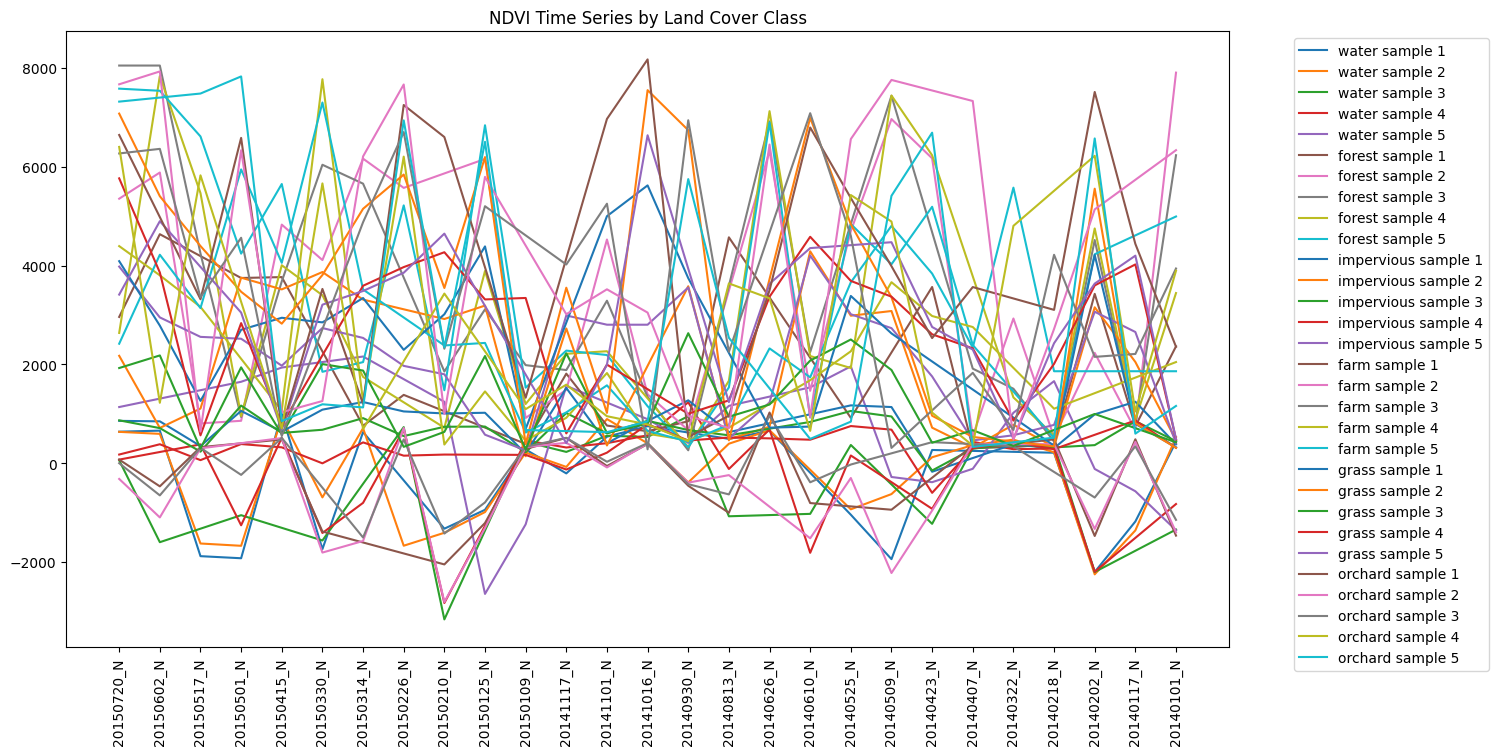

In [4]:
plt.figure(figsize=(15, 8))
for land_class in train_df['class'].unique():
    subset = train_df[train_df['class'] == land_class]
    for i in range(5):  # Plot 5 samples per class
        plt.plot(ndvi_cols, subset.iloc[i][ndvi_cols], label=f'{land_class} sample {i+1}')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('NDVI Time Series by Land Cover Class')
plt.show()

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = train_df.drop(['ID', 'class'], axis=1)
y = train_df['class']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.1)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_val_scaled)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")
print(classification_report(y_val, y_pred, target_names=le.classes_))

C:\Users\anukr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.914375
              precision    recall  f1-score   support

        farm       0.69      0.63      0.66       161
      forest       0.95      0.97      0.96      1231
       grass       0.87      0.79      0.83        43
  impervious       0.86      0.81      0.84       141
     orchard       0.00      0.00      0.00         6
       water       0.94      0.89      0.91        18

    accuracy                           0.91      1600
   macro avg       0.72      0.68      0.70      1600
weighted avg       0.91      0.91      0.91      1600



C:\Users\anukr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anukr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anukr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000), 
                          param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val_scaled)
print(f"Validation Accuracy with best model: {accuracy_score(y_val, y_pred)}")

C:\Users\anukr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\anukr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\anukr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\anukr\AppData\Local\Programs\Python\P

Best parameters: {'C': 1}
Best cross-validation score: 0.9145312499999999
Validation Accuracy with best model: 0.915625


In [9]:
X_test = test_df[X.columns]  
X_test_scaled = scaler.transform(X_test)

test_predictions_classes = le.inverse_transform(test_predictions)

submission = pd.DataFrame({
    'ID': test_df['ID'],
    'class': test_predictions_classes
})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


In [11]:
submission.to_csv('submission.csv', index=False, encoding='utf-8')

In [12]:
import os
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\anukr


In [13]:
train_df['ndvi_diff_total'] = train_df[ndvi_cols].iloc[:, -1] - train_df[ndvi_cols].iloc[:, 0]
test_df['ndvi_diff_total'] = test_df[ndvi_cols].iloc[:, -1] - test_df[ndvi_cols].iloc[:, 0]

In [14]:
train_df['ndvi_cumsum'] = train_df[ndvi_cols].cumsum(axis=1).iloc[:, -1]
test_df['ndvi_cumsum'] = test_df[ndvi_cols].cumsum(axis=1).iloc[:, -1]


In [15]:
def get_fft_values(row, n=10):
    values = np.fft.fft(row[ndvi_cols].fillna(0))
    real_part = np.abs(values[:n])
    return pd.Series(real_part)

fft_features_train = train_df.apply(get_fft_values, axis=1)
fft_features_test = test_df.apply(get_fft_values, axis=1)


C:\Users\anukr\AppData\Local\Temp\ipykernel_42340\1014025972.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  values = np.fft.fft(row[ndvi_cols].fillna(0))
C:\Users\anukr\AppData\Local\Temp\ipykernel_42340\1014025972.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  values = np.fft.fft(row[ndvi_cols].fillna(0))
C:\Users\anukr\AppData\Local\Temp\ipykernel_42340\1014025972.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To 

In [16]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k=30)
X_train_new = selector.fit_transform(X_train_scaled, y_train)
X_val_new = selector.transform(X_val_scaled)

In [17]:
from sklearn.model_selection import StratifiedKFold

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  
    'solver': ['lbfgs'],
}
grid_search = GridSearchCV(LogisticRegression(multi_class='multinomial', max_iter=2000),
                           param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')

In [18]:
for col in ndvi_cols:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(train_df[col].median())

In [20]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=30)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)

In [21]:
from sklearn.linear_model import LogisticRegression

best_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=1)
best_model.fit(X_train_selected, y_train)

y_val_pred = best_model.predict(X_val_selected)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

C:\Users\anukr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.90875
              precision    recall  f1-score   support

        farm       0.68      0.63      0.66       161
      forest       0.94      0.97      0.96      1231
       grass       0.85      0.77      0.80        43
  impervious       0.86      0.79      0.83       141
     orchard       0.00      0.00      0.00         6
       water       0.89      0.94      0.92        18

    accuracy                           0.91      1600
   macro avg       0.70      0.68      0.69      1600
weighted avg       0.90      0.91      0.91      1600



In [22]:
X_test = test_df[X.columns] 

X_test_scaled = scaler.transform(X_test)
X_test_selected = selector.transform(X_test_scaled) 

test_preds = best_model.predict(X_test_selected)
test_classes = le.inverse_transform(test_preds)

submission = pd.DataFrame({
    'ID': test_df['ID'],
    'class': test_classes
})
submission.to_csv('submission.csv', index=False)